In [157]:
# Importing Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import scipy.stats as stats
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [158]:
# Importing Datasets

df_train_inputs = pd.read_pickle("df_train_inputs.pkl")
df_train_target = pd.read_pickle("df_train_target.pkl")

df_val_inputs = pd.read_pickle("df_val_inputs.pkl")
df_val_target = pd.read_pickle("df_val_target.pkl")

df_test_inputs = pd.read_pickle('df_test_inputs.pkl')
df_test = pd.read_pickle("df_test.pkl")
df_test = df_test.drop(columns = ['Unnamed: 8'])

In [159]:
# Removing HomeId and AwayId columns

df_train_inputs = df_train_inputs[df_train_inputs.columns[2:]]
df_val_inputs = df_val_inputs[df_val_inputs.columns[2:]]
df_test_inputs = df_test_inputs[df_test_inputs.columns[2:]]

# Transforming column types (needed for Lasso later)

df_train_inputs.columns = df_train_inputs.columns.astype(str)
df_val_inputs.columns = df_val_inputs.columns.astype(str)
df_test_inputs.columns = df_test_inputs.columns.astype(str)

In [160]:
# Creating a function to retrieve MSE and MAE

def statisticFunction(preds, target = df_train_target, save_path=None, plot = True):

    mse = np.mean((preds - target) **2)
    mae = np.mean(abs(preds - target))
    if plot:
        plt.figure(figsize=(14, 7))
        sns.histplot(preds, kde=True, stat='density', label ='Predictions')
        sns.histplot(preds - target, kde=True, stat='density', label='Prediction Error')
        plt.title("Prediction Distribution")
        plt.legend()
        
        if save_path:
            plt.savefig(f"{save_path}.png", format='png', dpi=300, bbox_inches="tight")
        
        plt.show()

    print(f"Model MSE: {mse:.3f}")
    print(f"Model MAE: {mae:.3f}") 

    return mse, mae

In [161]:
# Null Model Tests

null_mse, null_mae = statisticFunction(np.mean(df_train_target), plot=False)

Model MSE: 12.097
Model MAE: 2.764


In [162]:
print("\n" + "--" * 100 + "\n")


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [163]:
### XGBoost

# Preparing XGBoost Matrices

dtrain = xgb.DMatrix(df_train_inputs, label = df_train_target)
dval = xgb.DMatrix(df_val_inputs, label = df_val_target)

In [164]:
# Training XGBoost Model through cross-validation

params = {
    'objective': 'reg:squarederror',
    'eval_metric': ['rmse', 'mae'],
    'eta': 0.01,
    'max_depth': 5
}

# 5-fold cross-validation
cv_results = xgb.cv(params, dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10)
cv_results_last = cv_results.tail(1)
print(cv_results_last)

# Computing statistics of interest
best_rmse = cv_results_last['test-rmse-mean'].values[0]
best_mse = best_rmse ** 2
best_mae = cv_results_last['test-mae-mean'].values[0]

print(f"XGBoost MSE: {best_mse:.3f}")
print(f"XGBoost MAE: {best_mae:.3f}")

    train-rmse-mean  train-rmse-std  train-mae-mean  train-mae-std  \
99         3.342746        0.013583        2.655177       0.013227   

    test-rmse-mean  test-rmse-std  test-mae-mean  test-mae-std  
99        3.384282       0.054954       2.687206      0.052075  
XGBoost MSE: 11.453
XGBoost MAE: 2.687


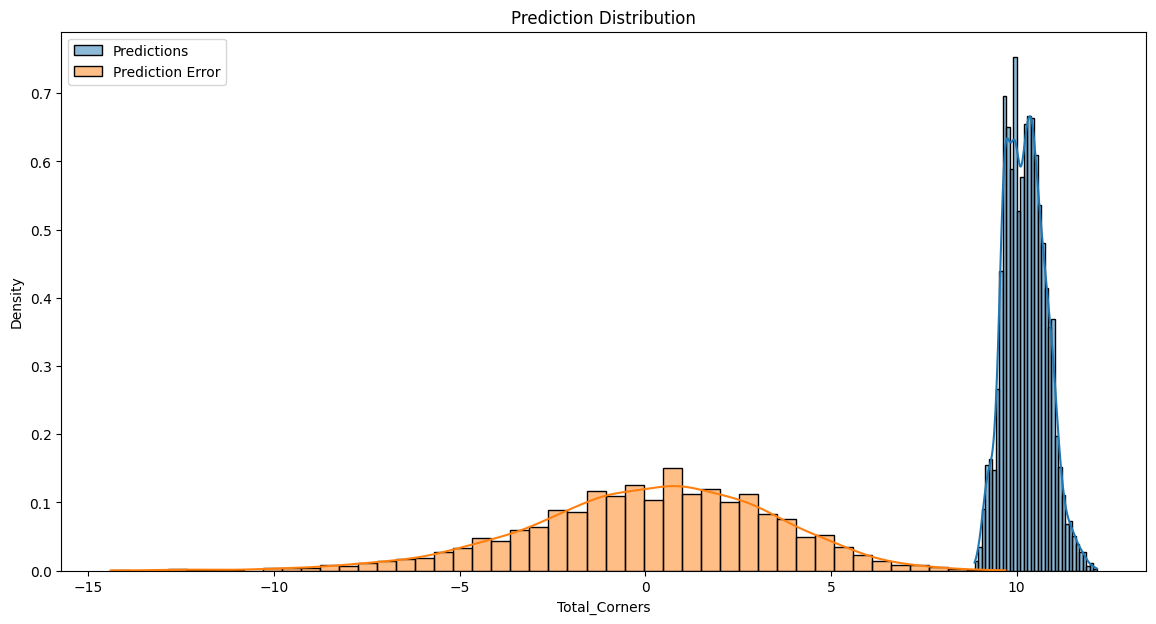

Model MSE: 10.804
Model MAE: 2.598


In [165]:
# Fitting best model

num_boost_round = len(cv_results)  # Use the best number of rounds from CV
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

xgb_preds = xgb_model.predict(dval)
xgb_mse, xgb_mae = statisticFunction(xgb_preds, df_val_target, save_path='xgb_preds_hist')


In [166]:
# XGBoost Grid Search

from sklearn.model_selection import RandomizedSearchCV

xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.6, 0.8, 1], # limit overfitting
    'colsample_bytree': [0.6, 0.8, 1], # preventing overfitting
    'min_child_weight': [1, 5, 10] # limit overfitting
}

xgb_grid_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_iter = 50, n_jobs=-1)
xgb_grid_search.fit(df_train_inputs, df_train_target)

print(xgb_grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'subsample': 1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


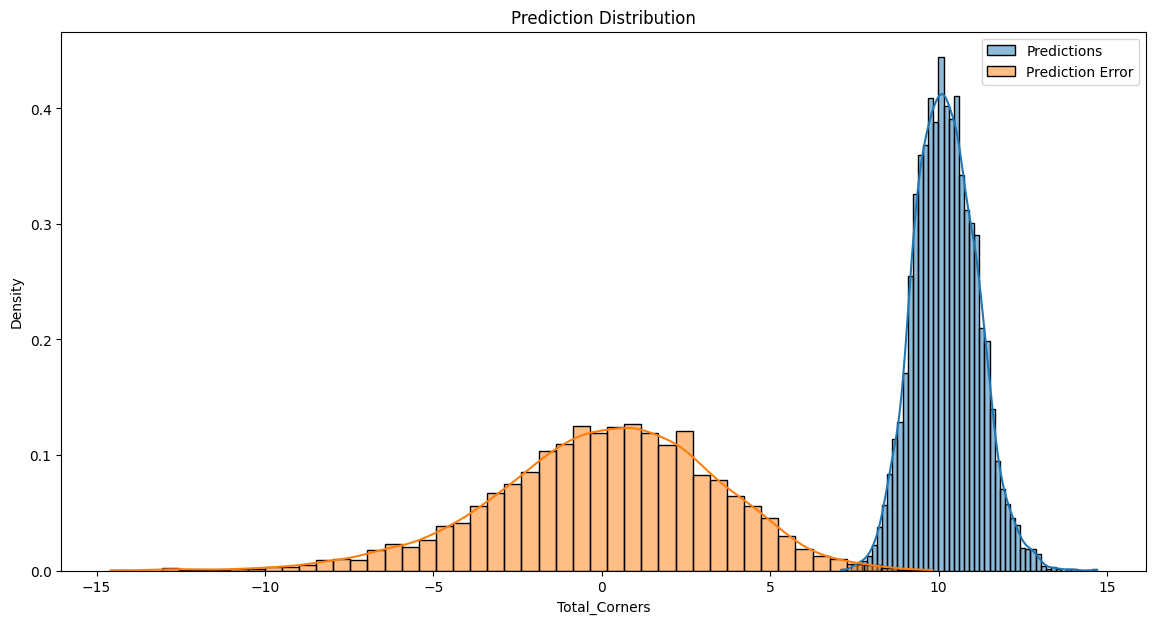

Model MSE: 10.741
Model MAE: 2.588


In [167]:
xgb_best_model =  xgb_grid_search.best_estimator_
xgb_best_model_preds = xgb_best_model.predict(df_val_inputs)

xgb_best_model_mse, xgb_best_model_mae = statisticFunction(xgb_best_model_preds, df_val_target, save_path='xgb_best_model_preds_hist')


In [168]:
print("\n" + "--" * 100 + "\n")


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [169]:
### Neural Network

# Transforming Data into tensors

import keras
import tensorflow as tf

tf_train = tf.data.Dataset.from_tensor_slices((df_train_inputs.astype('int64'), df_train_target.astype('int64')))
tf_val = tf.data.Dataset.from_tensor_slices((df_val_inputs.astype('int64'), df_val_target.astype('int64')))
tf_test = tf.data.Dataset.from_tensor_slices(df_test_inputs.astype('int64'))

In [170]:
# Preparing data

def preprocessing_data(dataset, batch_size):

    dataset = dataset.shuffle(3000).batch(batch_size)

    return dataset

tf_train = preprocessing_data(tf_train, 64)
tf_val = preprocessing_data(tf_val, 64)
tf_test = preprocessing_data(tf_test, 64)

In [171]:
# Building Model

from keras.layers import Dense, Input
from keras.models import Sequential

nn_model = Sequential([
    Input(shape = (21,)),
    Dense(10, activation = 'relu'),
    Dense(10, activation = 'relu'),
    Dense(1)
])

nn_model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4), loss = keras.losses.MeanSquaredError(), metrics = ['mae'])
nn_model.fit(tf_train, epochs = 100, steps_per_epoch = 5000, validation_data = tf_val, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01, restore_best_weights=True))

Epoch 1/100
 290/5000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 196.8334 - mae: 13.5503

/Users/apple/Downloads/Imperial/Betting Comp/new-env/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 3s 153us/step - loss: 178.5576 - mae: 12.8353 - val_loss: 131.9855 - val_mae: 10.9573
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 115us/step - loss: 100.4170 - mae: 9.3187 - val_loss: 62.9964 - val_mae: 7.1762
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 106us/step - loss: 41.5815 - mae: 5.4606 - val_loss: 19.7064 - val_mae: 3.5023
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 116us/step - loss: 15.4660 - mae: 3.0924 - val_loss: 13.2831 - val_mae: 2.8780
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 124us/step - loss: 13.6567 - mae: 2.9288 - val_loss: 13.0696 - val_mae: 2.8607
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - loss: 13.4390 - mae: 2.9076 - val_loss: 12.8748 - val_mae: 2.8392
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 107us/step - loss: 13.2406 - mae: 2.8873 - val_loss: 12.7023 - val_mae: 2.8198
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 112us/step - loss: 13.0956 - mae: 2.8715 - val_loss: 12.5535 - val_mae: 2.8034
Epoch 9/

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


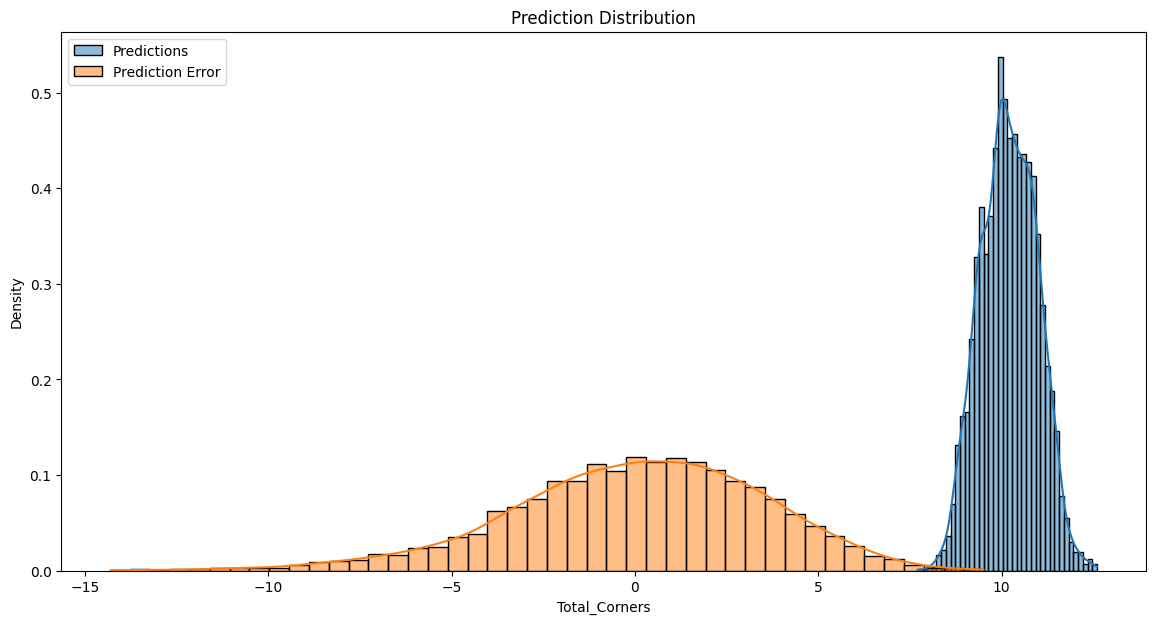

Model MSE: 11.859
Model MAE: 2.732


In [172]:
# Making test Predictions

nn_preds = nn_model.predict(tf_val)
nn_mse, nn_mae = statisticFunction(nn_preds.squeeze(), target=df_val_target, save_path='nn_preds_hist')

In [173]:
# Neural Network Random Search - Creating the model function

import keras_tuner as kt

def get_model(hp):


    layers = hp.Int('layers', min_value = 1, max_value = 5, step = 1)
    dropout_rate = hp.Float('dropout_rate', min_value = 0.0, max_value = 0.2, step = 0.05)
    activation_f = hp.Choice('activation', values=['relu', 'elu', 'swish'])
    learning_rate = hp.Float('learning_rate', min_value = 0.0001, max_value = 0.01, step = 0.0005)

    model = keras.Sequential()
    model.add(keras.layers.Input(shape = (21, )))

    for layer in range(layers):
        neurons = hp.Int(f'neurons_l{layer}', min_value = 10, max_value=100, step=10)
        model.add(keras.layers.Dense(neurons, activation=activation_f))
        BN = hp.Boolean(f'BN_l{layer}')
        if BN:
            model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate), loss = keras.losses.MeanSquaredError(), metrics=['mae'])

    return model
  

In [174]:
# Neural Network Random Search - Searching
import shutil

shutil.rmtree('my_tuner_results/hyperparam_tuning', ignore_errors=True)

from keras.callbacks import EarlyStopping

tuner = kt.RandomSearch(
    get_model,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory="my_tuning_dir",
    project_name="hyperparam_search",
    overwrite=True
)

early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

tuner.search((tf_train), validation_data=(tf_val), steps_per_epoch = 5000, epochs=100, callbacks=[early_stopping])

Trial 50 Complete [00h 00m 30s]
val_loss: 10.66693115234375

Best val_loss So Far: 10.659784317016602
Total elapsed time: 00h 21m 44s


{'layers': 2, 'dropout_rate': 0.0, 'activation': 'elu', 'learning_rate': 0.0096, 'neurons_l0': 80, 'BN_l0': False, 'neurons_l1': 70, 'BN_l1': True, 'neurons_l2': 50, 'BN_l2': False, 'neurons_l3': 70, 'BN_l3': False, 'neurons_l4': 80, 'BN_l4': False}
Epoch 1/100


/Users/apple/Downloads/Imperial/Betting Comp/new-env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 2s 180us/step - loss: 11.4023 - mae: 2.6811 - val_loss: 10.9704 - val_mae: 2.6376
Epoch 2/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 135us/step - loss: 11.3836 - mae: 2.6781 - val_loss: 11.4005 - val_mae: 2.6990
Epoch 3/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 131us/step - loss: 11.3928 - mae: 2.6779 - val_loss: 11.7945 - val_mae: 2.7591
Epoch 4/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 143us/step - loss: 11.3865 - mae: 2.6791 - val_loss: 10.7554 - val_mae: 2.6010
Epoch 5/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 134us/step - loss: 11.3638 - mae: 2.6762 - val_loss: 10.7207 - val_mae: 2.5758
Epoch 6/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 139us/step - loss: 11.4332 - mae: 2.6850 - val_loss: 10.6860 - val_mae: 2.5830
Epoch 7/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 256us/step - loss: 11.3712 - mae: 2.6779 - val_loss: 10.7001 - val_mae: 2.5698
Epoch 8/100
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1s 155us/step - loss: 11.3677 - mae: 2.6789 - val_loss: 11.1818 - val_mae: 2.6686
Epoch 9/100


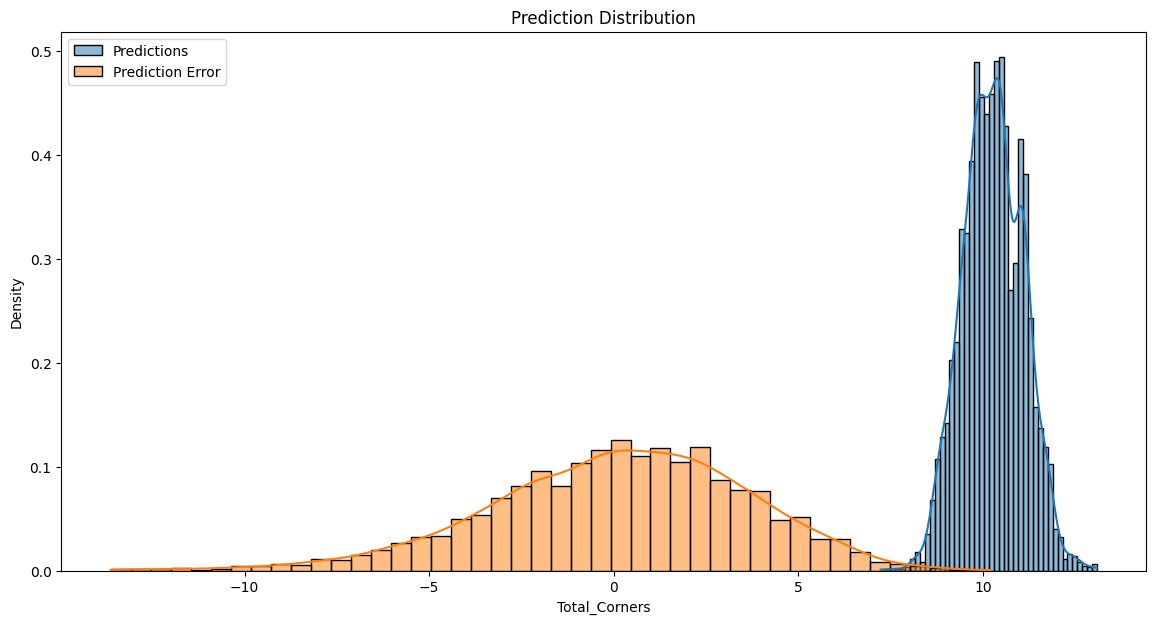

Model MSE: 12.062
Model MAE: 2.756


In [175]:
nn_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(nn_best_hps.values)

nn_best_model = tuner.get_best_models(num_models=1)[0]  # Get the best model
nn_best_model.fit(tf_train, validation_data=tf_val, steps_per_epoch=5000, epochs=100, callbacks=[early_stopping])
nn_best_preds = nn_best_model.predict(tf_val)
nn_best_mse, nn_best_mae = statisticFunction(nn_best_preds.squeeze(), target=df_val_target, save_path='nn_best_preds_hist')

In [176]:
print("\n" + "--" * 100 + "\n")


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [177]:
### GLM

# GLM - basic

import statsmodels.api as sm

X = sm.add_constant(df_train_inputs.astype('float'))
y = df_train_target

glm = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
glm_result = glm.fit()
print(glm_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Total_Corners   No. Observations:                18678
Model:                            GLM   Df Residuals:                    18657
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48760.
Date:                Tue, 25 Feb 2025   Deviance:                       20575.
Time:                        16:50:47   Pearson chi2:                 2.02e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09205
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/apple/Downloads/Imperial/Betting Comp/new-env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [178]:
# GLM - added non-linear features

df_train_inputs_transformed = df_train_inputs.copy()
df_train_inputs_transformed['Home_Avg_Corners_Squared'] = df_train_inputs_transformed['Home_Avg_Corners'] ** 2
df_train_inputs_transformed['Away_Avg_Corners_Squared'] = df_train_inputs_transformed['Away_Avg_Corners'] ** 2
df_train_inputs_transformed['Home_Avg_Corners_Conceded_Log'] = np.log(df_train_inputs_transformed['Home_Avg_Corners_Conceded'])
df_train_inputs_transformed['Away_Avg_Corners_Conceded_Log'] = np.log(df_train_inputs_transformed['Away_Avg_Corners_Conceded'])

df_val_inputs_transformed = df_val_inputs.copy()
df_val_inputs_transformed['Home_Avg_Corners_Squared'] = df_val_inputs_transformed['Home_Avg_Corners'] ** 2
df_val_inputs_transformed['Away_Avg_Corners_Squared'] = df_val_inputs_transformed['Away_Avg_Corners'] ** 2
df_val_inputs_transformed['Home_Avg_Corners_Conceded_Log'] = np.log(df_val_inputs_transformed['Home_Avg_Corners_Conceded'])
df_val_inputs_transformed['Away_Avg_Corners_Conceded_Log'] = np.log(df_val_inputs_transformed['Away_Avg_Corners_Conceded'])

X_poly = sm.add_constant(df_train_inputs_transformed.astype('float64'))

glm_poly = sm.GLM(y, X_poly, family=sm.families.Poisson(link=sm.families.links.log()))
glm_poly_result = glm_poly.fit()
print(glm_poly_result.summary())

/Users/apple/Downloads/Imperial/Betting Comp/new-env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:          Total_Corners   No. Observations:                18678
Model:                            GLM   Df Residuals:                    18653
Model Family:                 Poisson   Df Model:                           24
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -48759.
Date:                Tue, 25 Feb 2025   Deviance:                       20573.
Time:                        16:50:51   Pearson chi2:                 2.02e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.09215
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

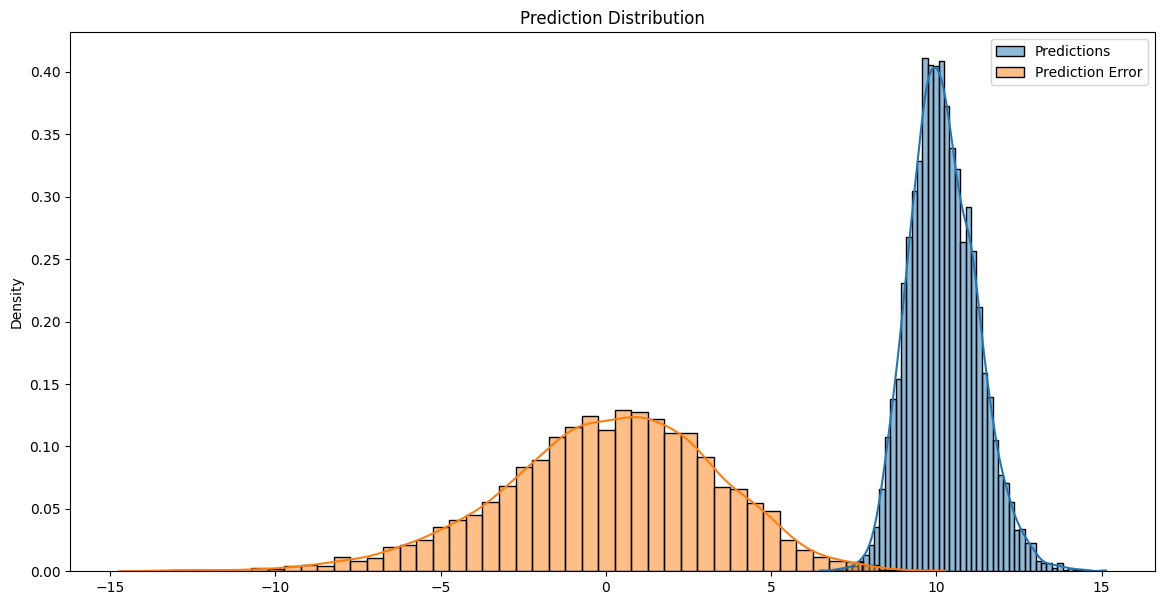

Model MSE: 10.561
Model MAE: 2.569


In [179]:
# Plotting predictions and errors for standard GLM

df_val_inputs_glm = sm.add_constant(df_val_inputs.astype('float64'))
glm_preds = glm_result.predict(df_val_inputs_glm)

glm_mse, glm_mae = statisticFunction(glm_preds, df_val_target, save_path = 'glm_preds_hist')

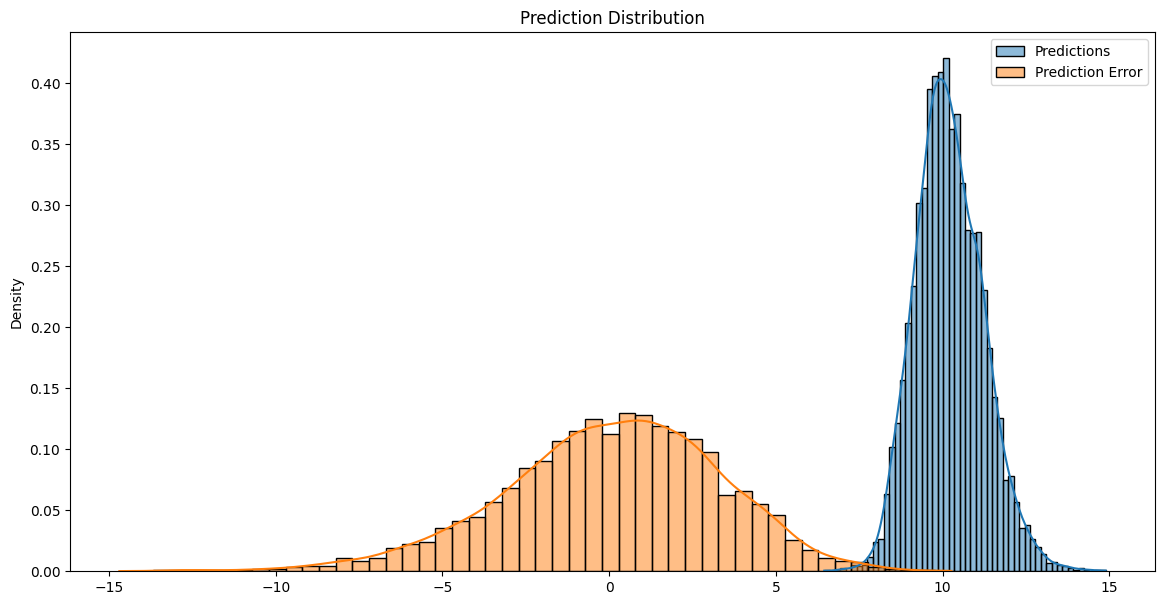

Model MSE: 10.566
Model MAE: 2.570


In [180]:
# Plotting results of extended GLM

df_val_inputs_transformed = sm.add_constant(df_val_inputs_transformed.astype('float64'))
glm_poly_preds =glm_poly_result.predict(df_val_inputs_transformed)

glm_poly_mse, glm_poly_mae = statisticFunction(glm_poly_preds, df_val_target, save_path = 'glm_extended_preds_hist')

In [181]:
# Chi-squared test

deviance_linear = glm_result.deviance
deviance_transformed = glm_poly_result.deviance 

df_linear = glm_result.df_resid 
df_transformed = glm_poly_result.df_resid

# Compute likelihood ratio test statistic
deviance_diff = deviance_linear - deviance_transformed
df_diff = df_linear - df_transformed  # Difference in degrees of freedom

# Compute p-value using chi-square distribution
from scipy.stats import chi2
p_value = chi2.sf(deviance_diff, df_diff)

print(f"Likelihood Ratio Test Statistic: {deviance_diff:.5f}")
print(f"Degrees of Freedom Difference: {df_diff}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The extended model significantly improves the fit (p < 0.05).")
else:
    print("No significant improvement in model fit.")

Likelihood Ratio Test Statistic: 2.07031
Degrees of Freedom Difference: 4
P-value: 0.7228
No significant improvement in model fit.


In [182]:
# Lasso regression for feature selection

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(df_train_inputs, df_train_target)
sig_variables = df_train_inputs.columns[lasso.coef_ != 0]
sig_variables

Index(['Home_Avg_Corners', 'Away_Avg_Corners', 'Home_Avg_Corners_Conceded',
       'Away_Avg_Corners_Conceded', '3_Game_Home_Conceded_Avg',
       '3_Game_Away_Conceded_Avg', '3_Game_Home_Avg', '3_Game_Away_Avg'],
      dtype='object')

In [183]:
# Fitting GLM model on selected features

df_val_opt_inputs = df_val_inputs[sig_variables]
df_val_opt_inputs = sm.add_constant(df_val_opt_inputs.astype('float'))
y = df_val_target
lasso_glm = sm.GLM(y, df_val_opt_inputs, family=sm.families.Poisson(link=sm.families.links.log()))
lasso_glm_result = lasso_glm.fit()

/Users/apple/Downloads/Imperial/Betting Comp/new-env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


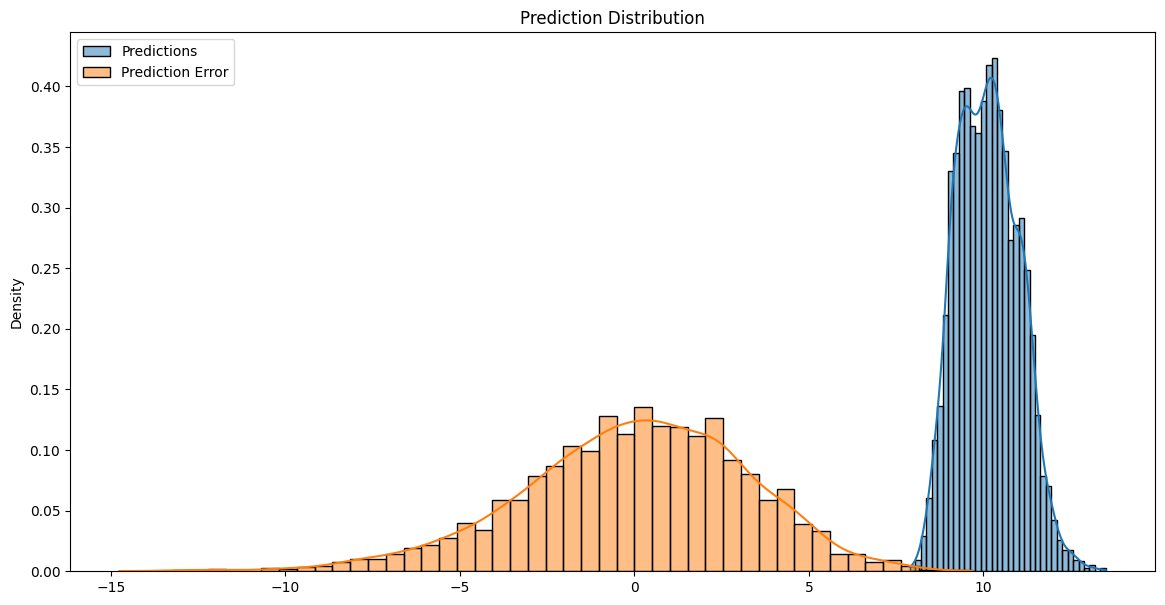

Model MSE: 10.530
Model MAE: 2.559


In [184]:
#Plotting Lasso Results

lasso_preds = lasso_glm_result.predict(df_val_opt_inputs)
lasso_mse, lasso_mae = statisticFunction(lasso_preds, df_val_target, save_path='lasso_preds_hist')

In [185]:
# Retraining on Full Dataset

df_train_full = pd.concat([df_train_inputs] + [df_val_inputs])
df_train_full = df_train_full[sig_variables]
df_train_full_target = pd.concat([df_train_target] + [df_val_target])

X = sm.add_constant(df_train_full.astype('float'))
y = df_train_full_target
lasso_glm = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
lasso_glm_result = lasso_glm.fit()

print(lasso_glm_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Total_Corners   No. Observations:                23348
Model:                            GLM   Df Residuals:                    23339
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60920.
Date:                Tue, 25 Feb 2025   Deviance:                       25691.
Time:                        16:50:56   Pearson chi2:                 2.53e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.08013
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/Users/apple/Downloads/Imperial/Betting Comp/new-env/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


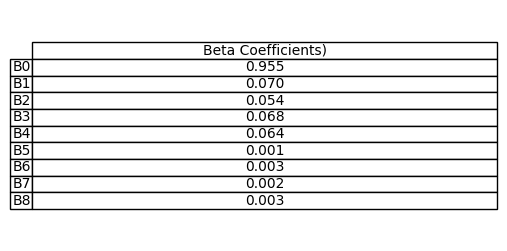

In [186]:
# Extracting coefficients

df_beta = pd.DataFrame({'Beta Coefficients)': lasso_glm_result.params.map(lambda x: f"{x:.3f}")})
df_beta.index = [f'B{i}' for i in range(len(df_beta))] 
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')

perf_table = ax.table(cellText=df_beta.values, colLabels=df_beta.columns, rowLabels = df_beta.index, cellLoc='center', loc='center')
plt.savefig("beta_coeff_table.png", dpi=300)

In [187]:
# Making test predictions

X = df_test_inputs[sig_variables]
X = sm.add_constant(X)
test_preds = lasso_glm_result.predict(X)

In [188]:
print("\n" + "--" * 100 + "\n")


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



In [189]:
# Placing Bets

import scipy.stats as stats

def get_proba_of_success(target, lambda_):
    return stats.poisson.cdf(k=target, mu=lambda_)

for i in range(341):
    target = df_test.Line[i]
    lambda_ = test_preds[i]

    if np.ceil(target) == np.floor(target):  # discrete case
        target_l = target - 1

        proba_push = stats.poisson.pmf(target, lambda_)
        proba_under = get_proba_of_success(target_l, lambda_)
        proba_over = 1 - get_proba_of_success(target, lambda_)

        df_test.loc[i, 'P(Under)'] = proba_under
        df_test.loc[i, 'P(At)'] = proba_push
        df_test.loc[i, 'P(Over)'] = proba_over

        if proba_push > proba_under and proba_push > proba_over or abs(proba_over - proba_under) < 0.05:
            df_test.loc[i, 'Bet (U/O)'] = 'No Bet'
        elif proba_under > proba_over:
            df_test.loc[i, 'Bet (U/O)'] = 'U'
        else:
            df_test.loc[i, 'Bet (U/O)'] = 'O'

    else:  # non-discrete case

        target_u = target + 0.5
        target_l = target - 0.5
        proba_under = get_proba_of_success(target_l, lambda_)
        proba_over = 1 - get_proba_of_success(target_l, lambda_)

        df_test.loc[i, 'P(Under)'] = proba_under
        df_test.loc[i, 'P(Over)'] = proba_over
        df_test.loc[i, 'P(At)'] = None


        if abs(proba_under - proba_over)< 0.05:
            df_test.loc[i, 'Bet (U/O)'] = 'No Bet'
        elif proba_under > proba_over:
            df_test.loc[i, 'Bet (U/O)'] = 'U'
        else:
            df_test.loc[i, 'Bet (U/O)'] = 'O'


/var/folders/45/x735h0c55fjg4v6l76_cz4x40000gn/T/ipykernel_15280/1986974230.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'No Bet' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[i, 'Bet (U/O)'] = 'No Bet'


In [190]:
df_test['P(At)'] =df_test['P(At)'].fillna(0)

In [191]:
print(df_test[df_test['Bet (U/O)']  == 'O'].shape)
print(df_test[df_test['Bet (U/O)'] == 'U'].shape)

(60, 13)
(209, 13)


In [192]:
# Adding Kelly Criterion

def kellyCriterionBet(dataset):

    def stakeValue(pw, pl, pd, r):

        return (pw * r - pl) / (r * (1 - pd))

    for i in range(len(dataset)):

        if dataset.loc[i, 'Bet (U/O)'] == 'U':
            pw = dataset.loc[i, 'P(Under)']
            pl = dataset.loc[i, 'P(Over)']
            pd = dataset.loc[i, 'P(At)']
            r = dataset.loc[i, 'Under']

        elif dataset.loc[i, 'Bet (U/O)'] == 'O':
            pw = dataset.loc[i, 'P(Over)']
            pl = dataset.loc[i, 'P(Under)']
            pd = dataset.loc[i, 'P(At)']
            r = dataset.loc[i, 'Over']

        else:
            dataset.loc[i, 'Stake'] = 0
            continue
        
        dataset.loc[i, 'Stake'] = stakeValue(pw, pl, pd, r)
            
kellyCriterionBet(df_test)


In [193]:
df_test

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake
0,1,741,2011-04-01,342,694,9.5,1.790,1.800,0.522166,0.000000,0.477834,No Bet,0.000000
1,2,741,2011-04-01,1424,270,11.5,1.920,2.000,0.570893,0.000000,0.429107,U,0.356340
2,3,729,2011-04-01,691,1137,10.5,1.970,1.870,0.470555,0.000000,0.529445,O,0.290584
3,4,729,2011-04-01,787,808,11.0,2.075,1.770,0.527045,0.117686,0.355269,U,0.369854
4,5,741,2011-04-01,784,1117,12.0,2.020,1.860,0.564686,0.110571,0.324743,U,0.438588
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,337,729,2011-05-22,1211,1118,10.5,1.950,1.961,0.503049,0.000000,0.496951,No Bet,0.000000
337,338,795,2011-05-22,1116,876,10.0,1.920,1.909,0.436721,0.124929,0.438350,No Bet,0.000000
338,339,801,2011-05-22,1223,771,10.0,2.020,1.840,0.502374,0.124329,0.373297,U,0.342018
339,340,801,2011-05-22,238,570,10.5,2.020,1.900,0.523966,0.000000,0.476034,No Bet,0.000000


In [194]:
# Normalising

df_test.Stake = df_test.Stake * (341/np.sum(df_test.Stake))

In [195]:
print("\n" + "--" * 100 + "\n")


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



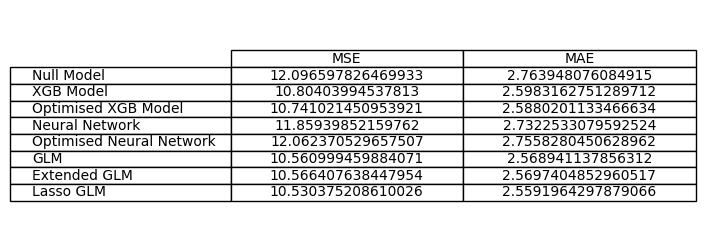

In [207]:
# Summary results

perf_table = pd.DataFrame([[null_mse, null_mae], [xgb_mse, xgb_mae], [xgb_best_model_mse, xgb_best_model_mae],[nn_mse, nn_mae], [nn_best_mse, nn_best_mae],
                           [glm_mse, glm_mae], [glm_poly_mse, glm_poly_mae], [lasso_mse, lasso_mae]], 
                            columns = ['MSE', 'MAE'], index = ['Null Model', 'XGB Model', 'Optimised XGB Model', 'Neural Network', 'Optimised Neural Network',
                                                               'GLM', 'Extended GLM', 'Lasso GLM'])

fig, ax = plt.subplots(figsize=(6, 3)) 
ax.axis('tight')
ax.axis('off')
perf_table = ax.table(cellText=perf_table.values, colLabels=perf_table.columns, rowLabels = perf_table.index, cellLoc='center', loc='center')
plt.savefig("perf_table.png", dpi=300, bbox_inches = 'tight')

# Saving to Excel

df_test.to_excel('df_test.xlsx', index=False)

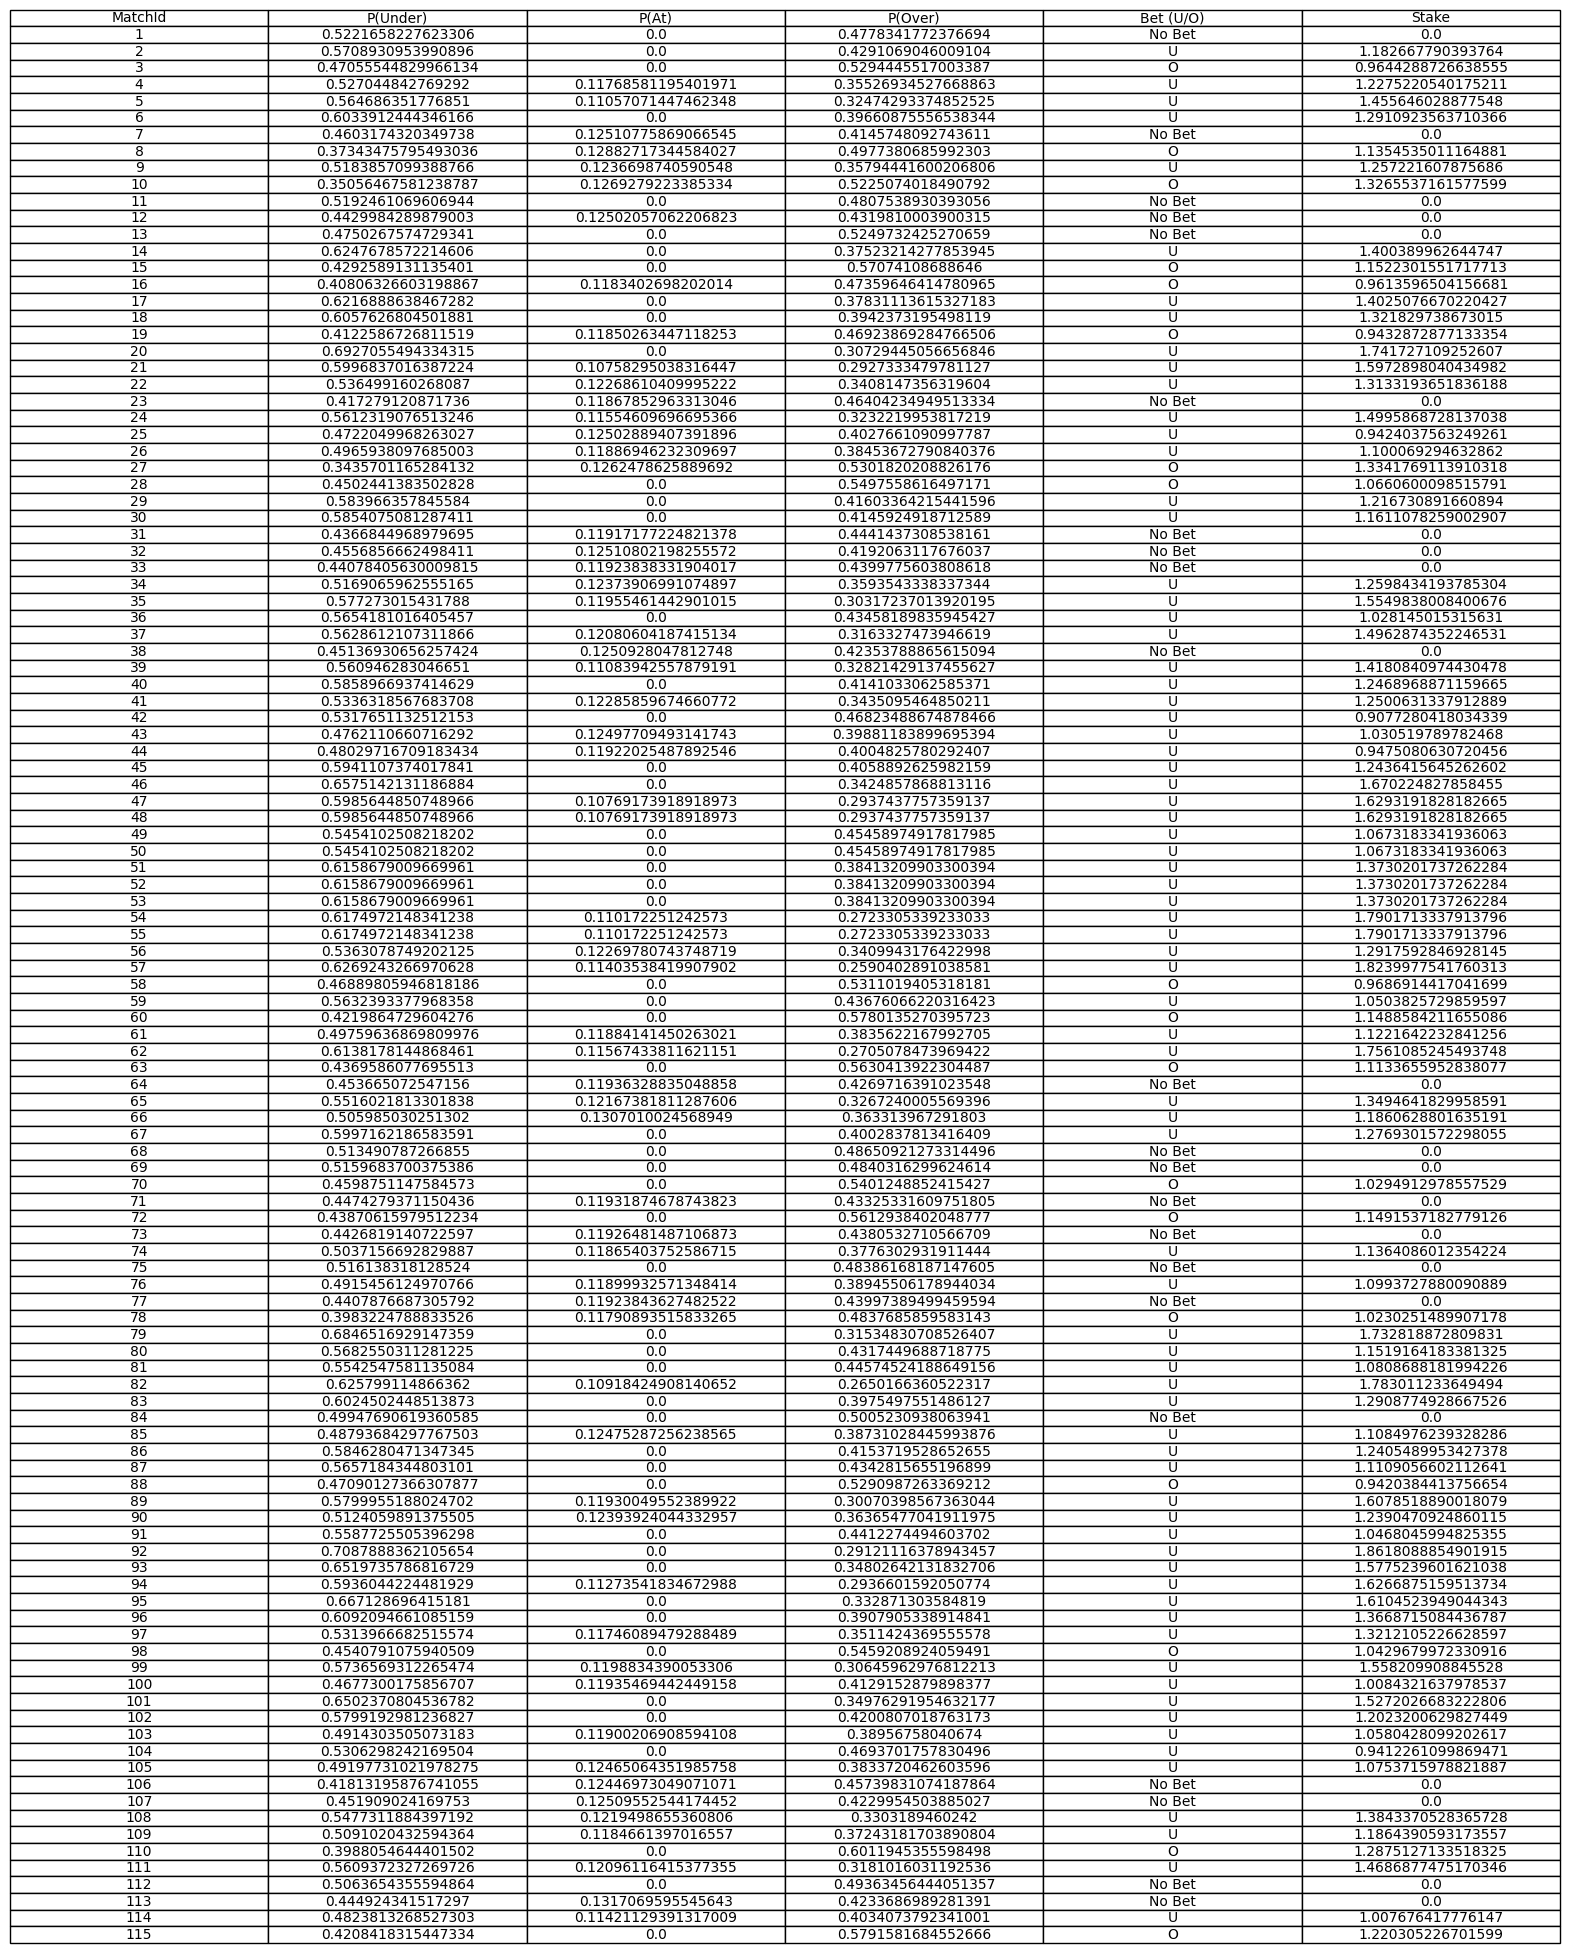

In [198]:
clean_table_1 = df_test.iloc[:115, [0, 8, 9, 10, 11, 12]]

fig, ax = plt.subplots(figsize=(20, 20))  # Increase height

ax.axis('tight')
ax.axis('off')

# Create the table
clean_table_1 = ax.table(cellText=clean_table_1.values, 
                       colLabels=clean_table_1.columns, 
                       cellLoc='center', 
                       loc='center')

# Save as a JPEG with higher DPI
plt.savefig("clean_table_1.jpeg", dpi=300, bbox_inches='tight')


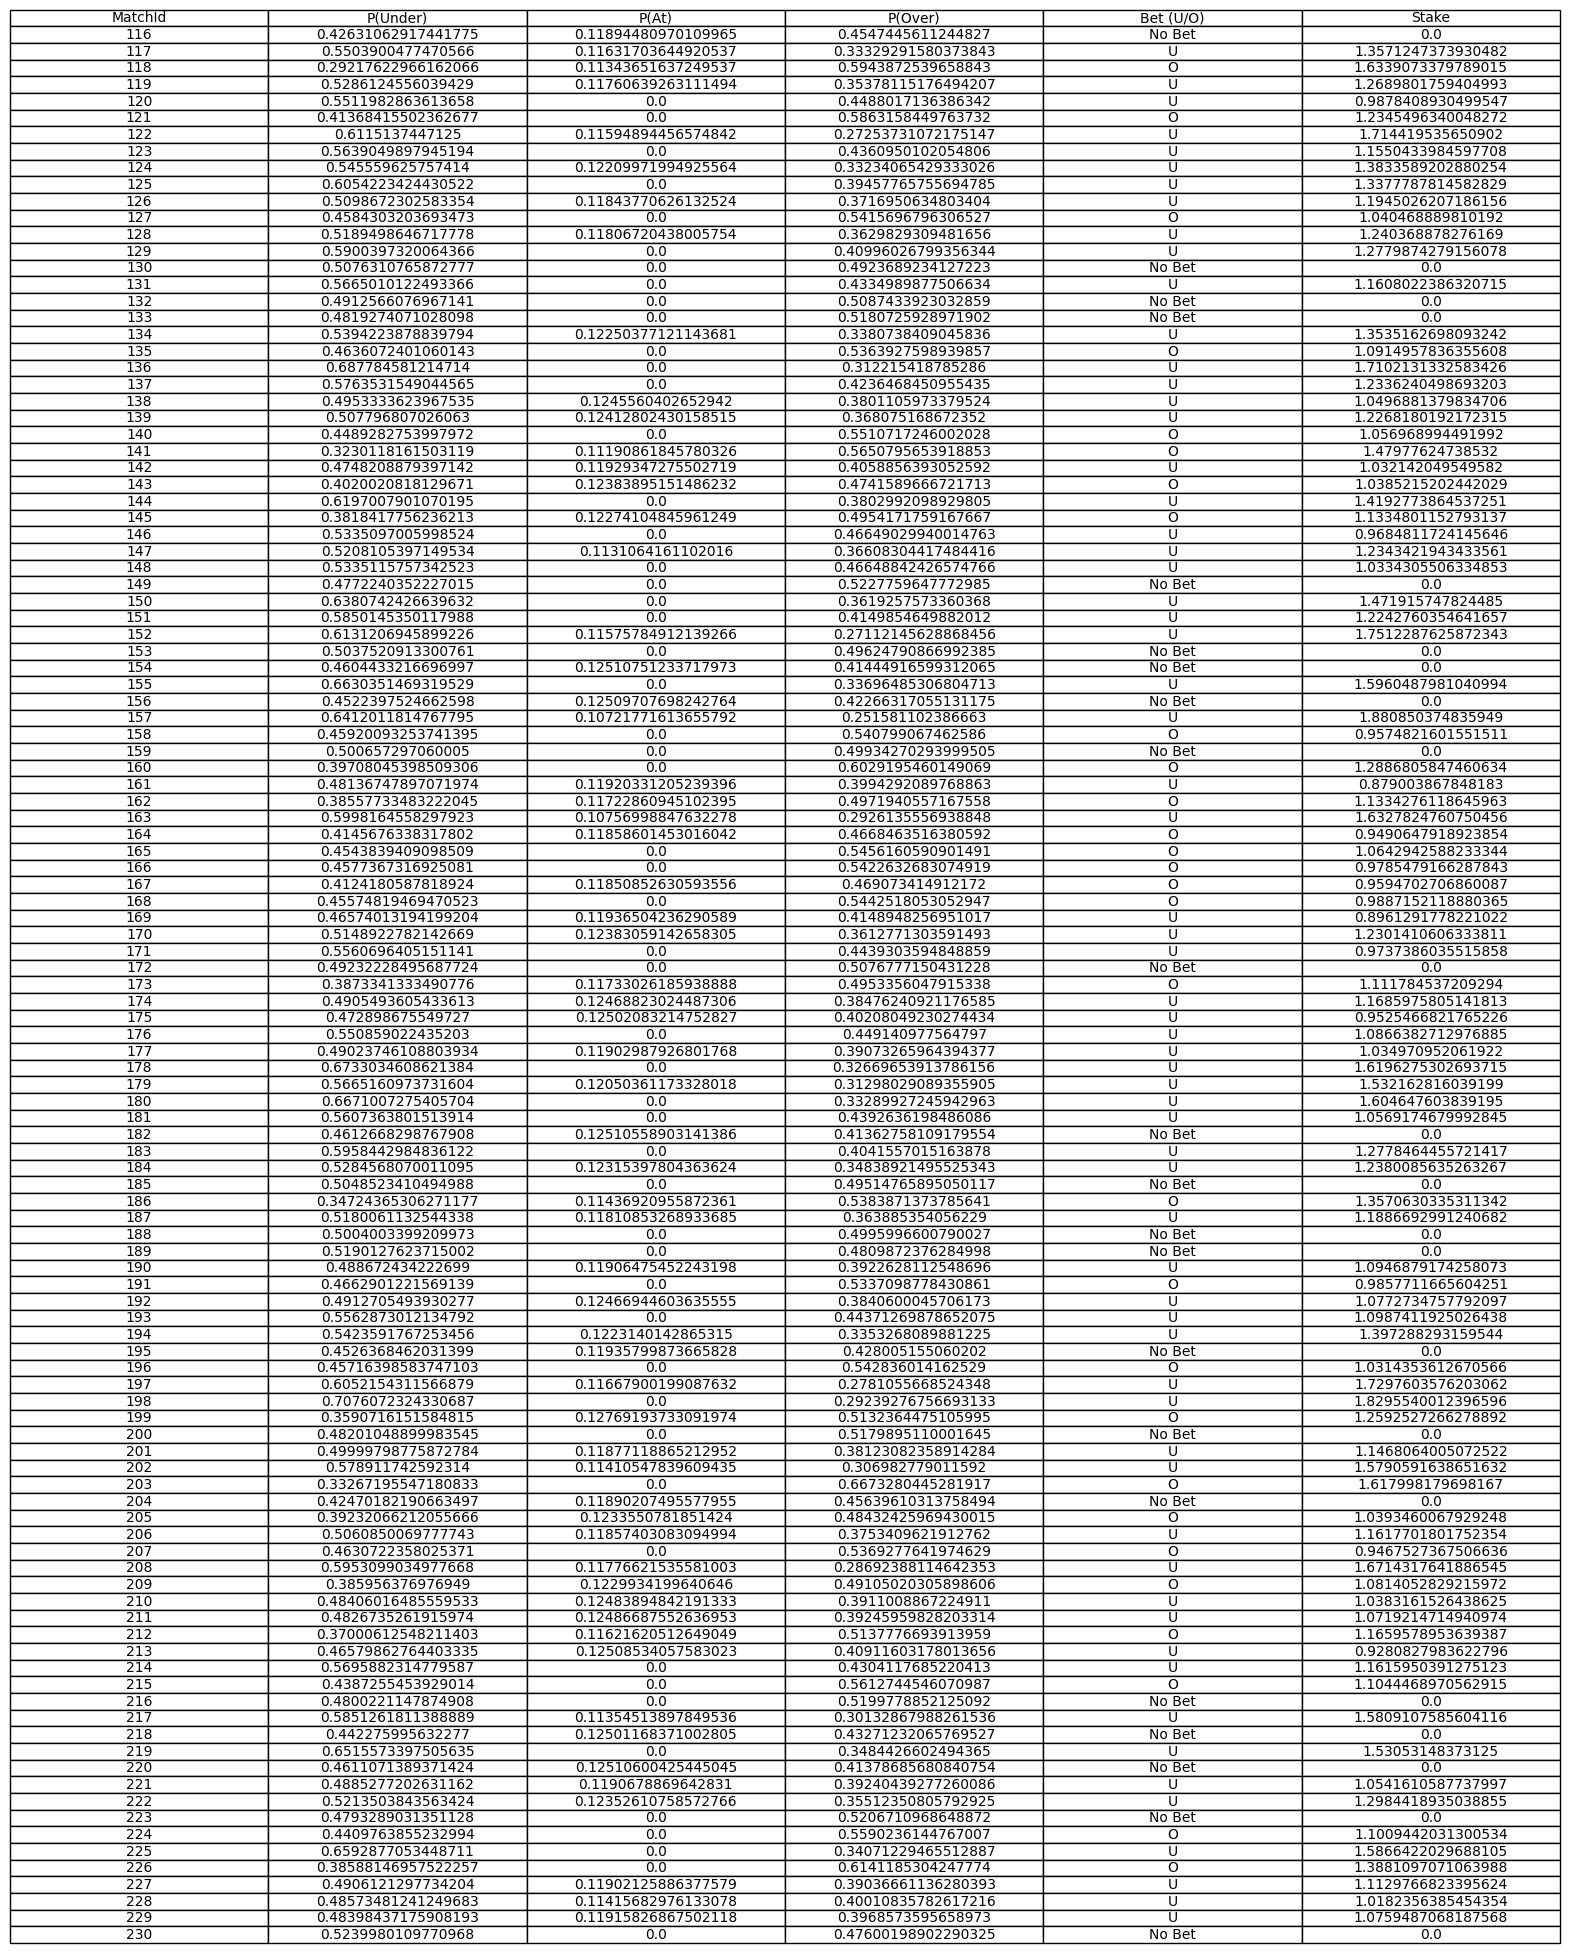

In [199]:
clean_table_2 = df_test.iloc[115:230, [0, 8, 9, 10, 11, 12]]

fig, ax = plt.subplots(figsize=(20, 20))  # Increase height

ax.axis('tight')
ax.axis('off')

# Create the table
clean_table_2 = ax.table(cellText=clean_table_2.values, 
                       colLabels=clean_table_2.columns, 
                       cellLoc='center', 
                       loc='center')

# Save as a JPEG with higher DPI
plt.savefig("clean_table_2.jpeg", dpi=300, bbox_inches='tight')

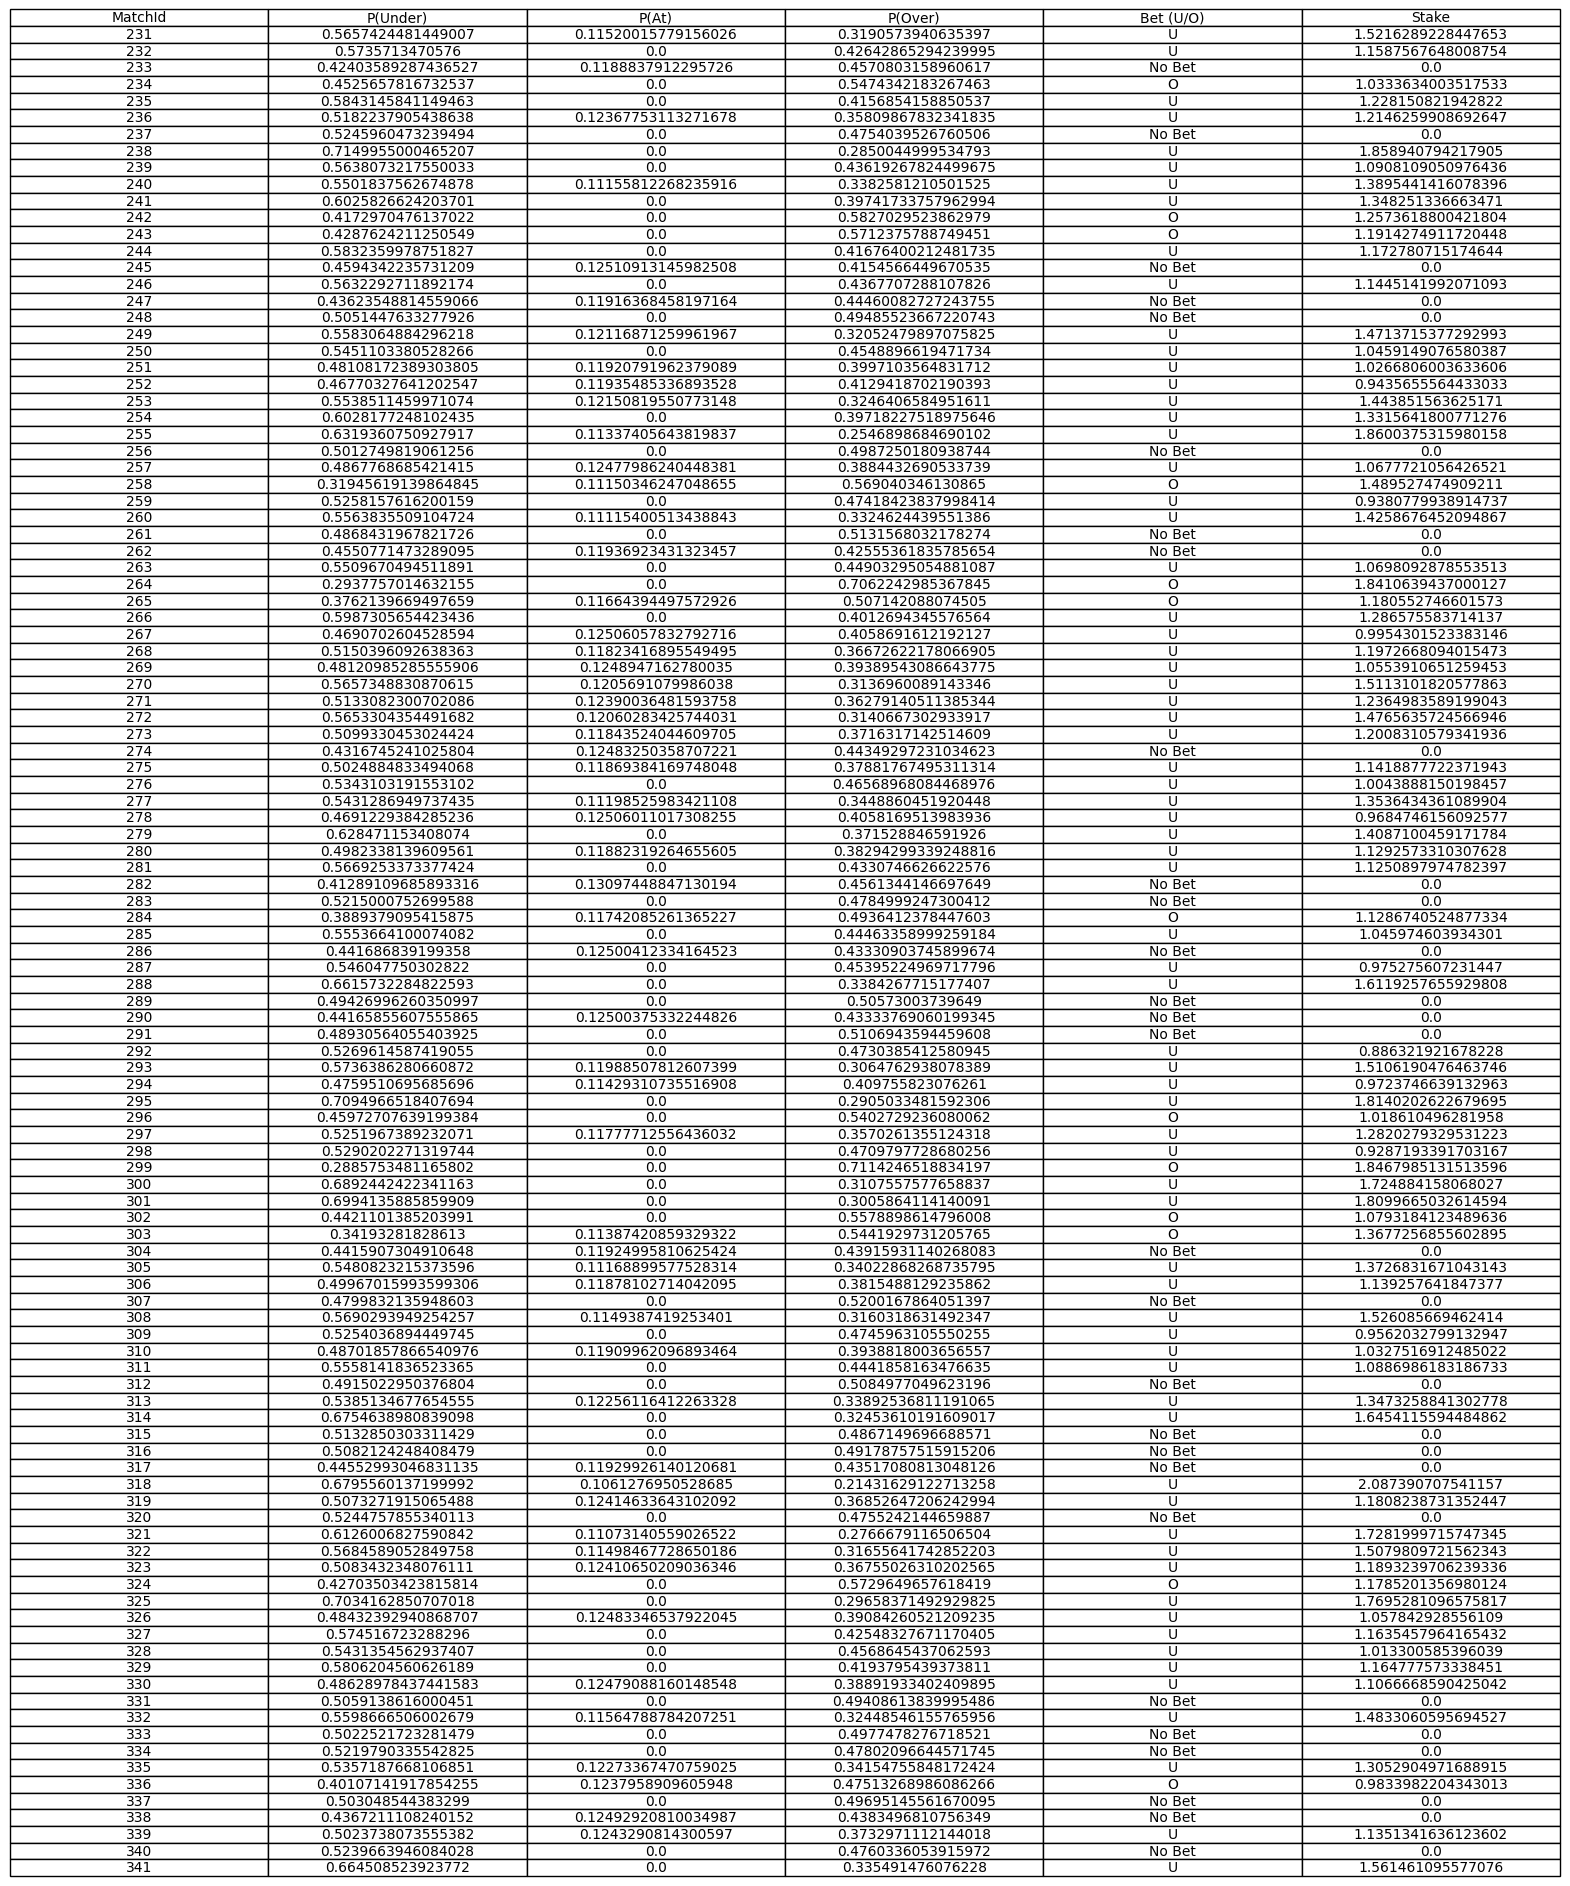

In [200]:
clean_table_3 = df_test.iloc[230:, [0, 8, 9, 10, 11, 12]]

fig, ax = plt.subplots(figsize=(20, 20))  # Increase height

ax.axis('tight')
ax.axis('off')

# Create the table
clean_table_2 = ax.table(cellText=clean_table_3.values, 
                       colLabels=clean_table_3.columns, 
                       cellLoc='center', 
                       loc='center')

# Save as a JPEG with higher DPI
plt.savefig("clean_table_3.jpeg", dpi=300, bbox_inches='tight')